In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# NEW! for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_21020/2479774028.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with different widths

In [2]:
n_per_class = 1000 # Total 2000 images
img_size    = 91

x    = np.linspace(start=-4, stop=4, num=img_size)
X, Y = np.meshgrid(x, x)

# The two widths (a.u.) sigma
widths = [1.8, 2.4]

# Initialize tensors containing images and labels
images = torch.zeros(2 * n_per_class, 1, img_size, img_size)
labels = torch.zeros(2 * n_per_class)

for i in range(2 * n_per_class):
    
    # Create the gaussian with random centers
    # Ro = random offset
    # `i % 2`: Even image belong to label 0
    ro = 2 * np.random.randn(2)
    G  = np.exp(-((X - ro[0]) ** 2 + (Y - ro[1]) ** 2) / (2 * widths[i % 2] ** 2))
    
    # And add noise
    G += np.random.randn(img_size, img_size) / 5
    
    # Add to the tensor
    # `.view`: Convert from numpy matrix to PTorch Tensor
    images[i, :, :, :] = torch.tensor(G).view(1, img_size, img_size)
    labels[i]          = i % 2

labels = labels[:, None]

# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                        shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                        batch_size=test_data_set.tensors[0].shape[0])

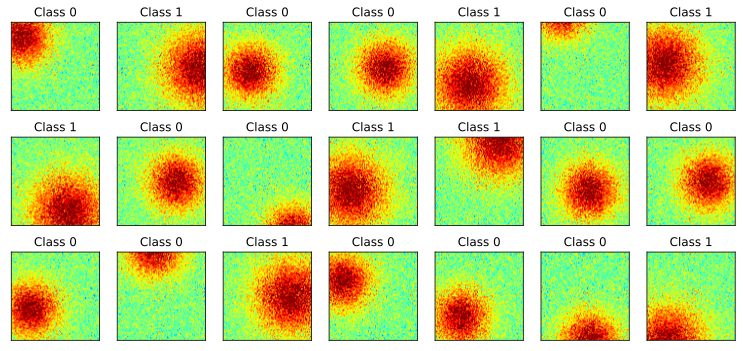

In [3]:
# Visualize some images
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for i, ax in enumerate(axs.flatten()):
    which_pic = np.random.randint(2 * n_per_class)
    G         = np.squeeze(images[which_pic, :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_title(f'Class {int(labels[which_pic].item())}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Create the DL model

In [4]:
def make_the_net():
    """
    CNN_GAUSS_FEATURE_MAPS
    """
    class gauss_net(nn.Module):
        def __init__(self):
            super().__init__()
            
            # Conv1
            self.conv1 = nn.Conv2d(1, 6, kernel_size=3, padding=1)
                # Out: (91 + 2*1 - 3)/1 + 1 = 91
                # Pool: 91 / 2 = 45
            
            # Conv2
            self.conv2 = nn.Conv2d(6, 4, kernel_size=3, padding=1)
                # Out: (45 + 2*1 - 3)/1 + 1 = 45
                # Pool: 45 / 2 = 22
            
            # Fc1
            self.fc1 = nn.Linear(22*22*4, 50)
            
            # Fc2 (output)
            self.fc2 = nn.Linear(50, 1)
        
        def forward(self, x):
            # First conv-pool set
            conv1_act = F.relu(self.conv1(x))
            x         = F.avg_pool2d(conv1_act, (2, 2))
            
            # Second conv-pool set
            conv2_act = F.relu(self.conv2(x))
            x         = F.avg_pool2d(conv2_act, (2, 2))
            
            # ANN part
            x = x.reshape(x.shape[0], -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            
            return x, conv1_act, conv2_act
    
    # Create the model instance
    net = gauss_net()
    
    # Loss Function
    loss_func = nn.BCEWithLogitsLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
    
    return net, loss_func, optimizer

In [5]:
# Test the model with one batch
net, loss_func, optimizer = make_the_net()

# Test that the model runs and can compute a loss
X, y                          = iter(train_loader).next()
y_hat, feat_map_1, feat_map_2 = net(X)
loss                          = loss_func(y_hat, y)

# Check sizes of outputs
print(f'Predicted category:      {y_hat.shape}')
print(f'Feature map after conv1: {feat_map_1.shape}')
print(f'Feature map after conv2: {feat_map_2.shape}')


Predicted category:      torch.Size([32, 1])
Feature map after conv1: torch.Size([32, 6, 91, 91])
Feature map after conv2: torch.Size([32, 4, 45, 45])


In [6]:
# Count the total number of parameters in the model
summary(model=net, input_data=(1, img_size, img_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 91, 91]           60
├─Conv2d: 1-2                            [-1, 4, 45, 45]           220
├─Linear: 1-3                            [-1, 50]                  96,850
├─Linear: 1-4                            [-1, 1]                   51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
Total mult-adds (M): 0.98
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 91, 91]           60
├─Conv2d: 1-2                            [-1, 4, 45, 45]           220
├─Linear: 1-3                            [-1, 50]                  96,850
├─Linear: 1-4                            [-1, 1]                   51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
Total mult-adds (M): 0.98
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84

# Create a function that trains the model

In [11]:
def train_the_model():
    """
    CNN_GAUSS_FEATURE_MAPS
    """
    
    num_epochs = 10

    # Create a new model
    net, loss_func, optimizer = make_the_net()

    # Initialize
    train_loss = torch.zeros(num_epochs)
    test_loss  = torch.zeros(num_epochs)
    train_acc  = torch.zeros(num_epochs)
    test_acc   = torch.zeros(num_epochs)

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Loop over training data batches
        batch_acc  = []
        batch_loss = [] 

        for X, y in train_loader:
            # Forward pass and loss
            y_hat = net(X)[0] # Only need the first output
            loss  = loss_func(y_hat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batch_loss.append(loss.item())
            batch_acc .append(torch.mean(((y_hat > 0) == y).float()).item())

        # End of batch loop.

        # Get the average training accuracy of the batches
        train_loss[epoch_i] = np.mean(batch_loss)
        train_acc [epoch_i] = 100 * np.mean(batch_acc)

        # Test accuracy
        X, y = next(iter(test_loader)) # Extract X, y from dataloader
        with torch.no_grad():
            y_hat = net(X)[0]
            loss  = loss_func(y_hat, y)
            
        test_loss[epoch_i] = loss.item()
        test_acc [epoch_i] = 100 * torch.mean(((y_hat > 0) == y).float()).item()

    # End epochs

    return train_loss, test_loss, train_acc, test_acc, net

# Run the model and show the results!

In [12]:
train_loss, test_loss, train_acc, test_acc, net = train_the_model()

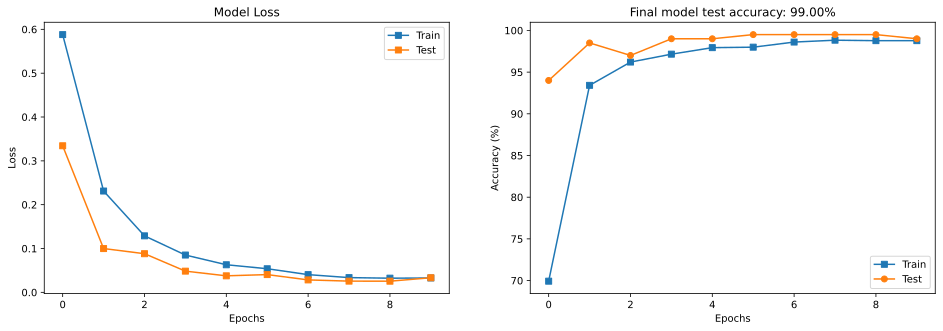

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, 's-', label='Train')
ax[0].plot(test_loss,  's-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend()

ax[1].plot(train_acc, 's-', label='Train')
ax[1].plot(test_acc,  'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}%')
ax[1].legend()

plt.show()

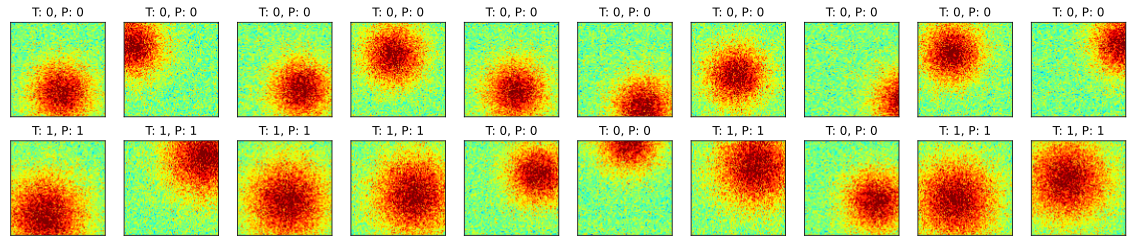

In [14]:
# Visualize some images
X, y                          = next(iter(test_loader))
y_hat, feat_map_1, feat_map_2 = net(X)

fig, axs = plt.subplots(2, 10, figsize=(20, 4))

for i, ax in enumerate(axs.flatten()):
    G = torch.squeeze(X[i, 0, :, :]).detach()
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    t = (int(y[i].item()), int(y_hat[i].item() > 0.5))
    ax.set_title(f'T: {t[0]}, P: {t[1]}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Draw the feature maps

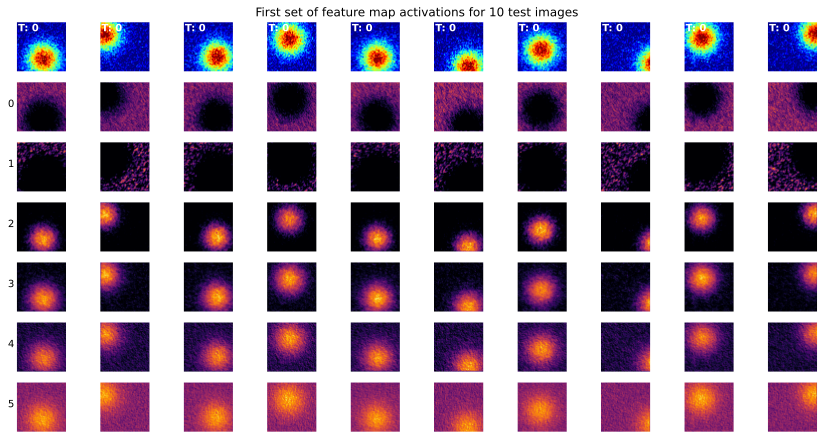

In [15]:
# From the conv1 layer
fig, axs = plt.subplots(7, 10, figsize=(12, 6))

# Loop over 10 pictures (First row)
for pic_i in range(10):
    # Show the original picture. `0`: Only one Gray channel
    img = X[pic_i, 0, :, :].detach()
    axs[0, pic_i].imshow(img, cmap='jet', vmin=0, vmax=1)
    axs[0, pic_i].axis('off')
    axs[0, pic_i].text(2, 2, f'T: {int(y[pic_i].item())}', ha='left', va='top', color='w', fontweight='bold')
    
    # Loop over 06 feature maps (Each column except the first row)
    for feat_i in range(6):
        # Extract the feature map from this image
        img = feat_map_1[pic_i, feat_i, :, :].detach()
        axs[feat_i + 1, pic_i].imshow(img, cmap='inferno', vmin=0, vmax=torch.max(img) * 0.9)
        axs[feat_i + 1, pic_i].axis('off')
        axs[feat_i + 1, pic_i].text(-5, 45, feat_i, ha='right') if (pic_i == 0) else None

plt.tight_layout()
plt.suptitle('First set of feature map activations for 10 test images', x=0.5, y=1.01)
plt.show()

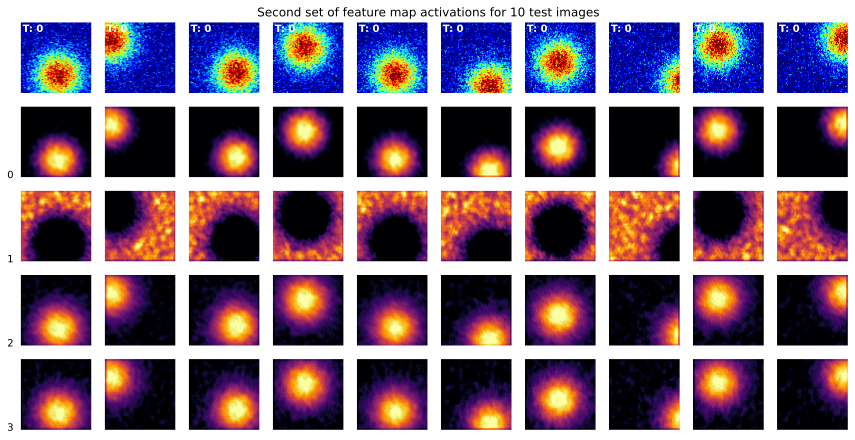

In [17]:
# From the conv2 layer
fig, axs = plt.subplots(5, 10, figsize=(12, 6))

# Loop over 10 pictures (First row)
for pic_i in range(10):
    # Show the original picture. `0`: Only one Gray channel
    img = X[pic_i, 0, :, :].detach()
    axs[0, pic_i].imshow(img, cmap='jet', vmin=0, vmax=1)
    axs[0, pic_i].axis('off')
    axs[0, pic_i].text(2, 2, f'T: {int(y[pic_i].item())}', ha='left', va='top', color='w', fontweight='bold')
    
    # Loop over 04 feature maps (Each column except the first row)
    for feat_i in range(4):
        # Extract the feature map from this image
        img = feat_map_2[pic_i, feat_i, :, :].detach()
        axs[feat_i + 1, pic_i].imshow(img, cmap='inferno', vmin=0, vmax=torch.max(img) * 0.9)
        axs[feat_i + 1, pic_i].axis('off')
        axs[feat_i + 1, pic_i].text(-5, 45, feat_i, ha='right') if (pic_i == 0) else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 10 test images', x=0.5, y=1.01)
plt.show()

# Spatial correlations across the feature maps

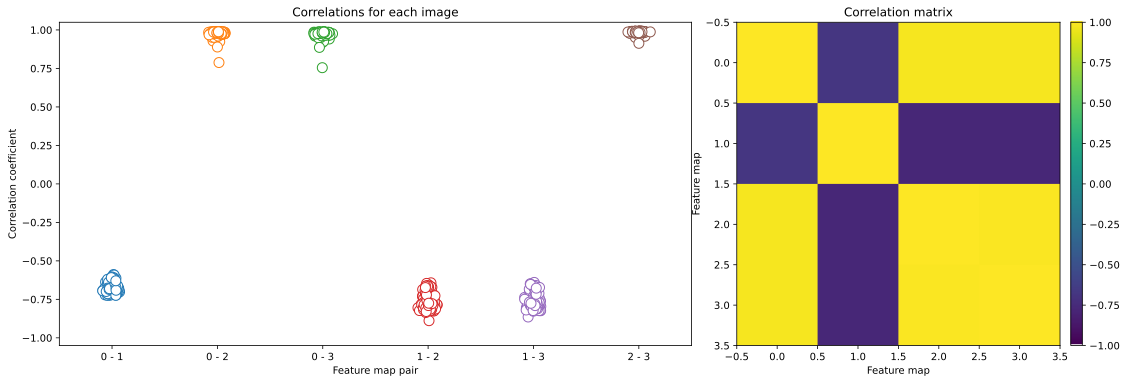

In [18]:
# Correlations across the SECOND convolution layer

# Convenient variables
n_stim = feat_map_2.shape[0]
n_maps = feat_map_2.shape[1]
n_cors = (n_maps * (n_maps - 1)) // 2

# Initialze the matrix of all correlation values
allrs = np.zeros((n_stim, n_cors))
Call  = np.zeros((n_maps, n_maps))

# Loop over each stimulus/image
for i in range(n_stim):
  
  # Extract the vectorized feature maps from this image
  # `.view(n_maps, -1)`: Reshape: Number of maps, total number of pixels with each feature maps
  feat_map = feat_map_2[i, :, :, :].view(n_maps, -1).detach()
  
  # Compute the correlation matrix. Correlation of each feature map pairs of 1 image
  C     = np.corrcoef(feat_map)
  Call += C
  
  # Extract the unique correlations from the matrix
  idx         = np.nonzero(np.triu(C, 1))
  allrs[i, :] = C[idx]

# Define the x-axis labels
x_lab = [] * n_cors
for i in range(n_cors):
  x_lab.append(f'{idx[0][i]} - {idx[1][i]}')

# Now visualize the correlations
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_axes([0.1, 0.1, 0.55, 0.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([0.68, 0.1, 0.3, 0.9])
cax = fig.add_axes([0.98, 0.1, 0.01, 0.9])

for i in range(n_cors):
  ax0.plot(i + np.random.randn(n_stim) / 30, allrs[:, i], 'o', markerfacecolor='w', markersize=10)

# Make the plot more interpretable
ax0.set_xlim([-.5, n_cors - .5])
ax0.set_ylim([-1.05, 1.05])
ax0.set_xticks(range(n_cors))
ax0.set_xticklabels(x_lab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')

# Now show the average correlation matrix
h = ax1.imshow(Call / n_stim, vmin=-1, vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')

# Add a colorbar
fig.colorbar(h, cax=cax)
plt.show()


In [ ]:
### correlations across the FIRST convolution layer

# convenient variables
nStim = featmap1.shape[0]
nMaps = featmap1.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap1[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

In [ ]:
# Note: We will explore how to examine feature map activations without modifying the network class in the lecture
#       "Pretraining with autoencoders" in the Transfer Learning section.

# Additional explorations

In [ ]:
# 1) The code here grabs the activation of the feature maps *after* relu is applied. Modify the code to get the *pre-relu* 
#    activations, which corresponds to the linear part of the activations. Redraw the maps (do you need to modify the
#    color range?). Do they look similar or different before vs after relu? Which maps are more relevant to interpret
#    when trying to understand how the CNN works and how it represents data?
# 
# 2) Relatedly, how much difference would it make to export the activations after the pooling layers? Which is better
#    and what are the advantages of inspecting the pre- vs. post-pooled activation maps?
# 